# Simulation and EM Maximization of the 2D Likelihood for scRNA-seq

In this exercise, I generate some data that (could) look like RNA seq in 2 dimension under some assumptions, and design a likelihood function that could recover (some) parameters.

I describe an EM-like optimization algorithm to approximately maximize this objective.

### Imports

In [7]:
%matplotlib inline

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW
import numpy as np
import itertools
import time
from scipy.stats import multivariate_normal

### 1D Likelihood Function

I define the log liklihood given data $x_1, x_2, x_3, x_4, ... , x_N$as follows:

$$ LL(p, \mu, \sigma ; x_1, x_2, x_3, x_4, ... , x_N) = \sum_{i=1}^{N}\log\bigg(\sum_{z=0}^{\infty} \bigg[{z\choose{x_i}}p^{x_i}(1-p)^{z-x_i}\bigg] \bigg[\frac{1}{\sqrt{2\pi\sigma^{2}}} \exp\bigg(-\frac{(z-\mu)^{2}}{2\sigma^{2}}\bigg)\bigg]\bigg) $$

### Ideal optimization problem

This likelihood function is obviously not concave (so maximizing is not a convex optimization problem), but it may be possible to design some optimization procedure for finding good parameters, given some reasonable constraints on $p$ the dropout rate and $\mu$ the mean estimated from either pseudobulks for bulk RNA-seq experiments.

The optimization problem we'd like to eventually solve is:

\begin{equation*}
\begin{aligned}
& \underset{p,\ \mu,\ \sigma}{\text{maximize}}
& & LL(p, \mu, \sigma ; x_1, x_2, x_3, x_4, ... , x_N) \\
& \text{subject to}
& & 0.05 < p < 0.15, \\
&&& \mu_{min}\ <\ \mu\ <\ \mu_{max}
\end{aligned}
\end{equation*}

The follow outlines an EM algorithm that converges to a local maximum of this objective.

### Simulation

Let us simulate a possible procedure for generadting scRNA-seq data in 1 dimension (1 gene case).


1. The underlying distribution Z is mean $\mu$ with variance $\sigma^{2}$, $Z \sim \mathcal{N}(\mu,\,\sigma^{2})\,.
$
2. Then, for each cell sampled from this distribution, we round to the nearest integer and sample a binomial random variable X distributed as $X \sim B(Z, p)$ where the sampled $Z$ serves as the number of trials and $p$ serves as the dropout rate of an individual transcript in a cell.

For this simulation, we use:
- $N$ = 100,000
- $\mu$ = 3
- $\sigma$ = 1
- $p$ = 0.1


In [9]:
def show_heatmap(coordinates):
    
    heatmap, xedges, yedges = np.histogram2d(
        coordinates[:, 0], 
        coordinates[:, 1], 
        bins=20, 
        range=[[-2, 10], [-2, 10]],
        normed=True)
    plt.imshow(
        heatmap.T, 
        interpolation='nearest',  
        origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        cmap='Reds')

In [10]:
# Parameters
num_cells = 100000
p = 0.1
mu = [3, 5]
sigma = [[3, 2],[2, 2]]

In [11]:
continuous_gaussian= multivariate_normal.rvs(mu, sigma, size=num_cells)

In [12]:
ground_truth_counts = np.clip(
    np.round(continuous_gaussian),
    a_min=0, 
    a_max=100).astype(np.int64)

In [13]:
observed = np.random.binomial(n=ground_truth_counts, p=p)

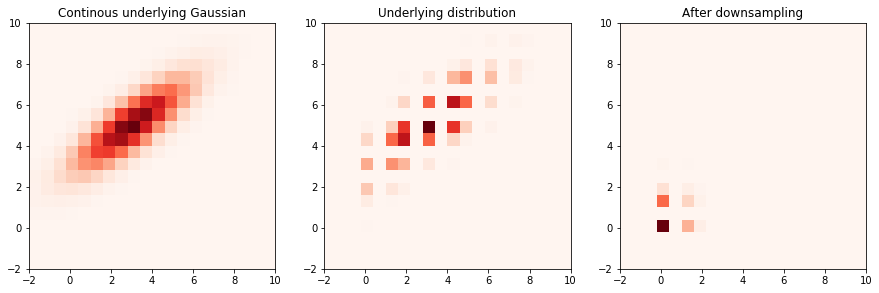

In [14]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1);
plt.title('Continous underlying Gaussian');
show_heatmap(continuous_gaussian)
plt.subplot(1, 3, 2);
plt.title('Underlying distribution')
show_heatmap(ground_truth_counts)
plt.subplot(1, 3, 3);
plt.title('After downsampling')
show_heatmap(observed)

In [21]:
data_path = '/Users/mincheolkim/Google Drive/UCSF/research/parameter_estimation/'

In [22]:
fitting_2d = pd.read_csv(data_path + 'simulated_2d_em_progress.csv')

In [25]:
fitting_2d.tail(5)

,iteration,mu_hat_1,mu_hat_2,sigma_hat_1_1,sigma_hat_1_2,sigma_hat_2_1,sigma_hat_2_2,p_hat
395,395,3.066402,4.983879,1.138376,0.847220,0.847220,2.108205,0.1
396,396,3.066398,4.983878,1.138363,0.847874,0.847874,2.108182,0.1
397,397,3.066394,4.983877,1.138351,0.848527,0.848527,2.108159,0.1
398,398,3.066389,4.983877,1.138339,0.849179,0.849179,2.108136,0.1
399,399,3.066385,4.983876,1.138327,0.849829,0.849829,2.108113,0.1


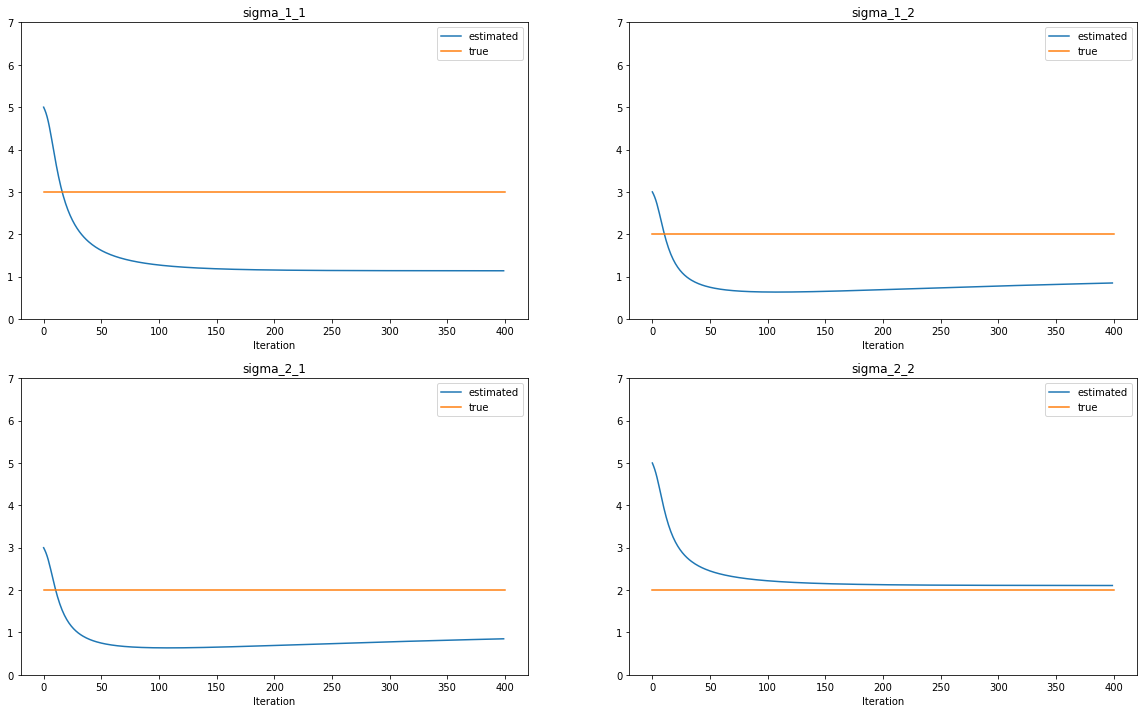

In [59]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1);
plt.plot(fitting_2d.iteration, fitting_2d.sigma_hat_1_1)
plt.plot([0, 400], [3, 3])
plt.title('sigma_1_1');plt.xlabel('Iteration'); plt.legend(['estimated', 'true'])
plt.ylim((0, 7))


plt.subplot(2, 2, 2);
plt.plot(fitting_2d.iteration, fitting_2d.sigma_hat_1_2)
plt.plot([0, 400], [2, 2])
plt.ylim((0, 7))
plt.title('sigma_1_2');plt.xlabel('Iteration'); plt.legend(['estimated', 'true'])

plt.subplot(2, 2, 3);
plt.plot(fitting_2d.iteration, fitting_2d.sigma_hat_2_1)
plt.plot([0, 400], [2, 2])
plt.ylim((0, 7))
plt.title('sigma_2_1');plt.xlabel('Iteration'); plt.legend(['estimated', 'true'])

plt.subplot(2, 2, 4);
plt.plot(fitting_2d.iteration, fitting_2d.sigma_hat_2_2)
plt.plot([0, 400], [2, 2])
plt.ylim((0, 7))
plt.title('sigma_2_2');plt.xlabel('Iteration'); plt.legend(['estimated', 'true'])

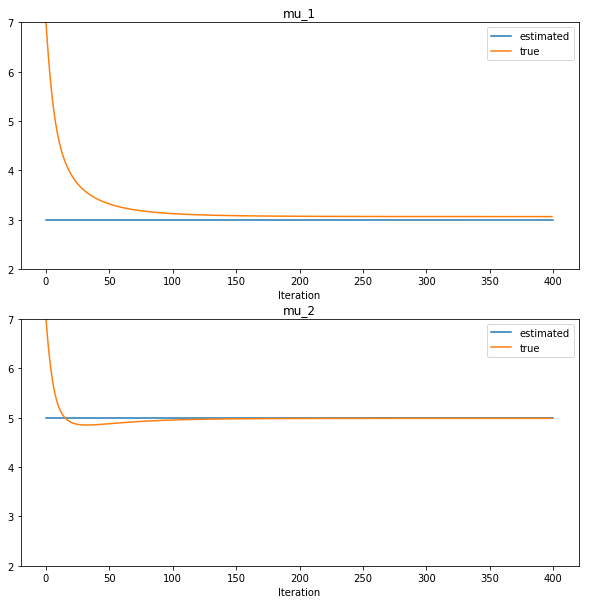

In [63]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot([0, fitting_2d.shape[0]], [3, 3])
plt.plot(fitting_2d.iteration, fitting_2d.mu_hat_1)
plt.ylim((2, 7));
plt.title('mu_1');
plt.xlabel('Iteration'); plt.legend(['estimated', 'true'])
plt.subplot(2, 1, 2)
plt.plot([0, fitting_2d.shape[0]], [5, 5])
plt.plot(fitting_2d.iteration, fitting_2d.mu_hat_2)
plt.ylim((2, 7))
plt.title('mu_2');
plt.xlabel('Iteration'); plt.legend(['estimated', 'true'])

In [70]:
reconstructed_contimuous = multivariate_normal.rvs(
    [fitting_2d.mu_hat_1.values[-1], fitting_2d.mu_hat_2.values[-1]],
    [[fitting_2d.sigma_hat_1_1.values[-1], fitting_2d.sigma_hat_1_2.values[-1]],[fitting_2d.sigma_hat_2_1.values[-1], fitting_2d.sigma_hat_2_2.values[-1]]],
    size=num_cells)

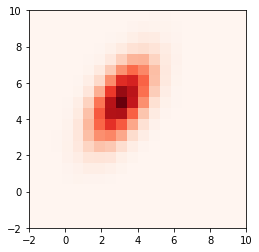

In [73]:
show_heatmap(reconstructed_contimuous)

In [74]:
reconstructed_discrete = np.clip(
    np.round(reconstructed_contimuous),
    a_min=0, 
    a_max=100).astype(np.int64)

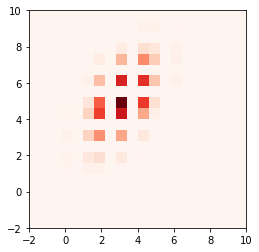

In [75]:
show_heatmap(reconstructed_discrete)

### Expectation step: Computing probabilities for Z

The expectation step of the EM algorithm involves calculating the probability of each possible value of Z the hidden variable (in our case, the true expression) given the parameters and the observations (X, mu, sigma, and p).

We use the Bayes rule to construct our probabilites for the hidden variables:

$ P(Z | X) = \frac{P(X|Z)P(Z)}{P(X)} $

Because of our distributional assumptions, we can evaluate each of the values on the RHS given p, mu, and sigma:

$
P(X|Z) = {z\choose{x}}p^{x}(1-p)^{z-x} \\
P(Z) = \frac{1}{\sqrt{2\pi\sigma^{2}}} \exp\big(-\frac{(z-\mu)^{2}}{2\sigma^{2}}\big) \\
P(X) = \sum_{z=0}^{\infty} \bigg[{z\choose{x}}p^{x}(1-p)^{z-x}\bigg]\bigg[\frac{1}{\sqrt{2\pi\sigma^{2}}} \exp\big(-\frac{(z-\mu)^{2}}{2\sigma^{2}}\big)\bigg]
$

In [98]:
def calculate_px(x1, x2, mu, sigma, p):
    z_candidates = np.array(list(itertools.product(np.arange(x1, 25), np.arange(x2, 25))))
    return (
        stats.binom.pmf(x1, z_candidates[:, 0], p) * \
        stats.binom.pmf(x2, z_candidates[:, 1], p) * \
        multivariate_normal.pdf(z_candidates, mean=mu, cov=sigma)
        ).sum()

In [101]:
def create_px_table(mu, sigma, p):
    
    px_table = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            px_table[i][j] = calculate_px(i, j, mu, sigma, p)
    return px_table

In [129]:
def create_pz_table(mu, sigma, p):
    """ Returns a matrix M x M where rows indicate X and columns indicate Z """
    
    px_table = create_px_table(mu, sigma, p)

    table = []
    for x1 in range(15):
        for x2 in range(15):
            for z1 in range(x1, 15):
                for z2 in range(x2, 15):
                    table.append((
                        x1, x2, z1, z2,
                        multivariate_normal.pdf([z1, z2], mean=mu, cov=sigma) * \
                        stats.binom.pmf(x1, z1, p) * \
                        stats.binom.pmf(x2, z2, p) / \
                        px_table[x1, x2]))
    return pd.DataFrame(table, columns=['x1', 'x2', 'z1', 'z2', 'latent_weight'])

In [130]:
pz_table = create_pz_table(mu, sigma, p)

In [138]:
pz_table.sample(n=5)

,x1,x2,z1,z2,latent_weight
10679,7,5,14,14,0.000007
823,0,4,1,6,0.001977
4706,2,8,6,10,0.008902
7471,4,7,12,10,0.000120
6959,4,3,5,8,0.022586


### Maximization step: Fit a weighted Gaussian on the latent variables

The maximization step in the EM algorithm involves using the calculated values of $P(Z|X)$ above to fit new values of the parameters mu, sigma, and p.

In the 1D case, this is rather simple: we expand out each observation $ X = i $ to ~30 different values with different weights. For example, if we observed a cell with $ X = 1 $, we create 20 rows for this cell with different values of Z that it could have had. Then, we fit a Gaussian (calculate mean and variance) on those Z values, with using the previously calculated $P(Z|X)$ as weights. More concretely, we calculate the mean and variance as follows, when we consider the upper limit of $Z$ to be $Z_{max}$:

$
\hat{\mu} = \frac{1}{N} \sum_{i=1}^{N} \bigg( \sum_{z=x_i}^{Z_{max}}\big[ P(z|x_i)(z)    \big]\bigg) \\
\hat{\sigma}^2 = \frac{1}{N-1}\sum_{i=1}^{N}\bigg( \sum_{z=x_i}^{Z_{max}}\big[ P(z|x_i)(z - \hat{\mu})^2 \big]\bigg)
$

In [156]:
def get_parameters(observed, prob_table):
    """ Get the parameters of the Gaussian and dropout """
    
    data = pd.DataFrame(observed, columns=['x1', 'x2'])
    
    data = data.groupby(['x1', 'x2']).size().reset_index(name='count')
    data['observed_weight'] = data['count'] / len(observed)
    
    data = data.merge(
        prob_table,
        on=['x1', 'x2'],
        how='left')

    data['point_weight'] = data['observed_weight'] * data['latent_weight']
    stat_estimates = DescrStatsW(data[['z1', 'z2']], weights=data['point_weight'])
    p_estimate =0.1
    return stat_estimates.mean, stat_estimates.cov, p_estimate

In [157]:
mean_hat, cov_hat, p_hat = get_parameters(observed, pz_table)

In [163]:
mu

[3, 5]

In [164]:
sigma

[[3, 2], [2, 2]]

### Perform EM

In [165]:
# Initialize hyperparameters for EM
NUM_ITER = 300

In [166]:
# Initialize the parameters
p_hat = 0.1
mu_hat = [7, 7]
sigma_hat = [[5, 3], [3, 5]]

In [167]:
fitting_progress = []
for itr in range(NUM_ITER):
    
    if itr % 5 == 0:
        print('Iteration: {}'.format(itr))
    
    fitting_progress.append((
        itr, 
        mu_hat[0], 
        mu_hat[1],
        sigma_hat[0,0], 
        sigma_hat[0,1],
        sigma_hat[1,0],
        sigma_hat[1,1],
        p_hat))
    
    # E step
    prob_table = create_pz_table(mu_hat, sigma_hat, p_hat)
    
    # M step
    mu_hat, sigma_hat, p_hat = get_parameters(observed, prob_table)

Iteration: 0
Iteration: 5
Iteration: 10
Iteration: 15
Iteration: 20
Iteration: 25


KeyboardInterrupt: 

In [39]:
fitting_progress = pd.DataFrame(fitting_progress, columns=['iteration', 'mu_hat', 'sigma_hat', 'p_hat'])

Text(0.5,1,'variance')

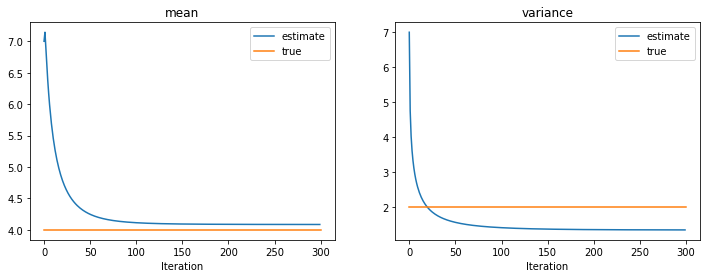

In [40]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(fitting_progress.iteration, fitting_progress.mu_hat)
plt.plot([0, NUM_ITER], [mu, mu])
plt.xlabel('Iteration'); plt.legend(['estimate', 'true']); plt.title('mean')
plt.subplot(1, 2, 2)
plt.plot(fitting_progress.iteration, fitting_progress.sigma_hat)
plt.plot([0, NUM_ITER], [sigma, sigma])
plt.xlabel('Iteration'); plt.legend(['estimate', 'true']); plt.title('variance')

### Re-create the original distribution

Sample a Gaussian normal with the estimated parameters.

In [41]:
reconstructed_counts = np.clip(np.round(np.random.normal(mu_hat, sigma_hat, size=num_cells)), a_min=0, a_max=100).astype(np.int64)

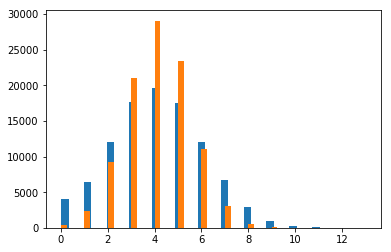

In [42]:
plt.hist(ground_truth_counts, bins=40);
plt.hist(reconstructed_counts, bins=40);